In [26]:
# import dependencies 
import tensorflow as tf
import numpy as np 
import pandas as pd 
from datetime import datetime, date, time
import os 
import glob
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
##importing dependencies 
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS 

token = "A1hvR7pmPINW66Wuxbb7dpwR74TukBJIC7IuP3ADhr4xTx0Zzx-JZxzgInUUFbikMsg_bNo2TI4QnbXnUIOkDg=="
org = "ThirdYearProject"
bucket = "86cf3b0e0c4d6c44"

##connect to influxdb
client = InfluxDBClient(url="http://localhost:8086", token=token, org=org)

In [28]:
## query data

query_api = client.query_api()
#tables = query_api.query_data_frame('from(bucket:"MicrosoftData")\
#|> range(start:  2015-08-23T00:00:00Z, stop: 2015-08-23T11:59:59Z)\
#|> filter(fn: (r) => r._measurement == "Network Prediction")\
#|> pivot(rowKey:["_time"], columnKey:["_field"], valueColumn:"_value")\
#|> keep(columns: ["Q-Factor", "Polarization Mode Dispersion","Transmit Power (dBm)"])')
#|> filter(fn: (r) => r._field == "Chromatic Dispersion(ps/nm)")\
#|> aggregateWindow(every: 1h, fn:mean, createEmpty:false)')
#print(tables)

query = 'from(bucket:"MicrosoftData")\
|> range(start:  2016-02-01T00:00:00Z, stop: 2016-03-01T11:59:59Z)\
|> filter(fn: (r) => r._measurement == "Network Prediction")\
|> pivot(rowKey:["_time"], columnKey:["_field"], valueColumn:"_value")\
|> keep(columns: ["_time", "Polarization Mode Dispersion"])'
#|> aggregateWindow(every:1h, fn:mean,createEmpty:false)

data = query_api.query_data_frame(query)
data.set_index("_time", inplace=True)
data.index = pd.to_datetime(data.index)
data.drop('result', axis=1, inplace=True)
data.drop('table', axis=1, inplace=True)
data.head()

,Polarization Mode Dispersion
_time,
2016-02-01 00:00:00+00:00,10.99
2016-02-01 00:15:00+00:00,10.91
2016-02-01 00:30:00+00:00,10.08
2016-02-01 00:45:00+00:00,10.27
2016-02-01 01:00:00+00:00,9.97


In [29]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Polarization Mode Dispersion,2832.0,9.397362,0.789863,7.72,8.79,9.31,9.8825,12.66


In [44]:
##iterating over queried data 

#time, value = [], []

#for table in tables: 
    #for row in table.records: 
        #time.append(row.values.get('_time'))
        #value.append(row.values.get('_value'))
        
## assigning column names, making Timestamp the index
#data = pd.DataFrame({'Timestamp':time, 'Q-Factor':value})
#data['Timestamp'].dt.date
#data.set_index(data['Timestamp'], drop = True, inplace = True)
#data.drop('Timestamp', axis=1, inplace=True)
print(len(data))

2832


In [39]:
##checking for erroneous data 
data.describe().transpose()
data.head()

,Polarization Mode Dispersion
_time,
2016-02-01 00:00:00+00:00,10.99
2016-02-01 00:15:00+00:00,10.91
2016-02-01 00:30:00+00:00,10.08
2016-02-01 00:45:00+00:00,10.27
2016-02-01 01:00:00+00:00,9.97


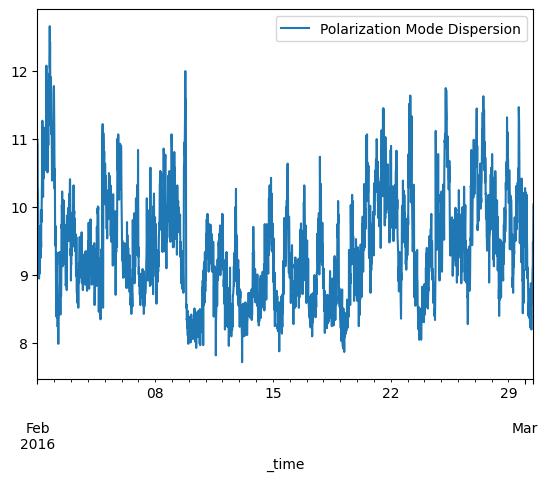

In [40]:
plot_cols=["Polarization Mode Dispersion"]
plot_features=data[plot_cols]
plot_features.index=data.index
_=plot_features.plot(subplots=True)

In [41]:
# converting data to numpy for better/faster processing 
time_index = np.array(data.index)
data = np.array(data['Polarization Mode Dispersion'])

In [54]:
# Train-test-validation split 
n=len(data)
train_data = data[:int(n*0.7)]
train_time = time_index[:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
val_time = time_index[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]
test_time = time_index[int(n*0.9):]

In [55]:
# finding mean and standard deviation in order to normalise data
# should really be done using moving average
#train_mean = train_data.mean()
#train_std = train_data.std()

# normalising 
#train_data = (train_data - train_mean)/train_std
#val_data = (val_data - train_mean)/train_std
#test_data = (test_data - train_mean)/train_std

# examining distribution features
#data_std = (data - train_mean) / train_std
#data_std = data_std.melt(var_name='Column', value_name='Normalized')
#plt.figure(figsize=(12, 6))
#ax = sns.violinplot(x='Column', y='Normalized', data=data_std)
#_ = ax.set_xticklabels(data.keys(), rotation=90)

In [64]:
# required parameters

WINDOW_SIZE = 36
BATCH_SIZE = 32
SHUFFLE_BUFFER = 3000

# function to create input features
## data converted -> TensorFlow dataset
## window function called, to create different input features
## flat_map to preserve order of time series by flattening data 
## shuffle and create batches of data for training a DL model

def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size+1))
    ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    ts_data = ts_data.batch(batch_size).prefetch(1)
    return ts_data #expanding data into tensors 

tensor_train_data = tf.expand_dims(train_data, axis=-1)
tensor_test_data = tf.expand_dims(test_data, axis=-1)
tensor_val_data = tf.expand_dims(val_data, axis=-1)

# generating input and output features for training and testing set 
tensor_train_dataset = ts_data_generator(tensor_train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
tensor_test_dataset = ts_data_generator(tensor_test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
tensor_val_dataset = ts_data_generator(tensor_val_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

AttributeError: 'PrefetchDataset' object has no attribute 'head'

In [59]:
# building model 
model = tf.keras.models.Sequential([
    #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
    #                      input_shape=[None]),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    #tf.keras.layers.Dense(1),
    #tf.keras.layers.Lambda(lambda x: x * 100.0)
    tf.keras.layers.Dense(10, input_shape=[WINDOW_SIZE], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# optimiser algorithm adjust weights of network's neurons and learning rate
# reduces loss and improves overall accuracy
optimiser = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiser, metrics=["mae"])
history = model.fit(tensor_train_dataset, epochs=200, validation_data=tensor_test_dataset)

Epoch 1/200
61/61 [==============================] - 1s 7ms/step - loss: 2.1346 - mae: 2.5485 - val_loss: 0.3068 - val_mae: 0.6677
Epoch 2/200
61/61 [==============================] - 1s 4ms/step - loss: 0.2602 - mae: 0.5907 - val_loss: 0.2388 - val_mae: 0.5762
Epoch 3/200
61/61 [==============================] - 1s 4ms/step - loss: 0.1902 - mae: 0.4873 - val_loss: 0.2647 - val_mae: 0.6039
Epoch 4/200
61/61 [==============================] - 1s 3ms/step - loss: 0.1575 - mae: 0.4395 - val_loss: 0.1712 - val_mae: 0.4861
Epoch 5/200
61/61 [==============================] - 1s 4ms/step - loss: 0.1444 - mae: 0.4181 - val_loss: 0.1709 - val_mae: 0.4787
Epoch 6/200
61/61 [==============================] - 1s 4ms/step - loss: 0.1590 - mae: 0.4459 - val_loss: 0.1847 - val_mae: 0.5040
Epoch 7/200
61/61 [==============================] - 1s 4ms/step - loss: 0.1230 - mae: 0.3772 - val_loss: 0.1629 - val_mae: 0.4621
Epoch 8/200
61/61 [==============================] - 1s 4ms/step - loss: 0.1274 - m

61/61 [==============================] - 0s 3ms/step - loss: 0.0660 - mae: 0.2756 - val_loss: 0.0716 - val_mae: 0.2949
Epoch 64/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0811 - mae: 0.3151 - val_loss: 0.0701 - val_mae: 0.2894
Epoch 65/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0867 - mae: 0.3300 - val_loss: 0.0700 - val_mae: 0.2859
Epoch 66/200
61/61 [==============================] - 1s 4ms/step - loss: 0.0630 - mae: 0.2709 - val_loss: 0.0933 - val_mae: 0.3460
Epoch 67/200
61/61 [==============================] - 1s 4ms/step - loss: 0.0669 - mae: 0.2783 - val_loss: 0.0688 - val_mae: 0.2824
Epoch 68/200
61/61 [==============================] - 1s 4ms/step - loss: 0.0632 - mae: 0.2728 - val_loss: 0.0683 - val_mae: 0.2831
Epoch 69/200
61/61 [==============================] - 1s 4ms/step - loss: 0.0706 - mae: 0.2905 - val_loss: 0.0686 - val_mae: 0.2850
Epoch 70/200
61/61 [==============================] - 1s 4ms/step - loss: 0.0648 - mae: 0

Epoch 125/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0591 - mae: 0.2614 - val_loss: 0.0961 - val_mae: 0.3522
Epoch 126/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0637 - mae: 0.2738 - val_loss: 0.0683 - val_mae: 0.2826
Epoch 127/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0566 - mae: 0.2564 - val_loss: 0.0763 - val_mae: 0.3024
Epoch 128/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0578 - mae: 0.2618 - val_loss: 0.0661 - val_mae: 0.2778
Epoch 129/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0573 - mae: 0.2588 - val_loss: 0.0733 - val_mae: 0.2948
Epoch 130/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0571 - mae: 0.2577 - val_loss: 0.0751 - val_mae: 0.2994
Epoch 131/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0573 - mae: 0.2600 - val_loss: 0.0860 - val_mae: 0.3273
Epoch 132/200
61/61 [==============================] - 0s 2ms/step - 

61/61 [==============================] - 0s 3ms/step - loss: 0.0611 - mae: 0.2686 - val_loss: 0.0730 - val_mae: 0.2940
Epoch 187/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0564 - mae: 0.2574 - val_loss: 0.0768 - val_mae: 0.3067
Epoch 188/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0524 - mae: 0.2459 - val_loss: 0.0674 - val_mae: 0.2801
Epoch 189/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0550 - mae: 0.2542 - val_loss: 0.0761 - val_mae: 0.3044
Epoch 190/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0562 - mae: 0.2562 - val_loss: 0.0744 - val_mae: 0.3000
Epoch 191/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0580 - mae: 0.2637 - val_loss: 0.0717 - val_mae: 0.2909
Epoch 192/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0639 - mae: 0.2748 - val_loss: 0.0643 - val_mae: 0.2748
Epoch 193/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0543 -

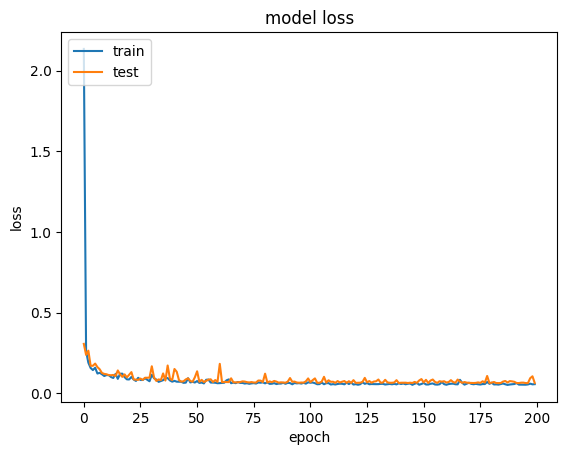

In [60]:
## losses of the model

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
def model_forecast(model, data, window_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

forecast = model_forecast(model, data[...,np.newaxis], WINDOW_SIZE)
forecast = forecast[int(n*0.7) - WINDOW_SIZE:-1, -1, 0]

error = tf.keras.metrics.mean_absolute_error(test_data, forecast).numpy()
print(error)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
# testing the model (need to find some info on this)

AttributeError: 'list' object has no attribute 'plot'

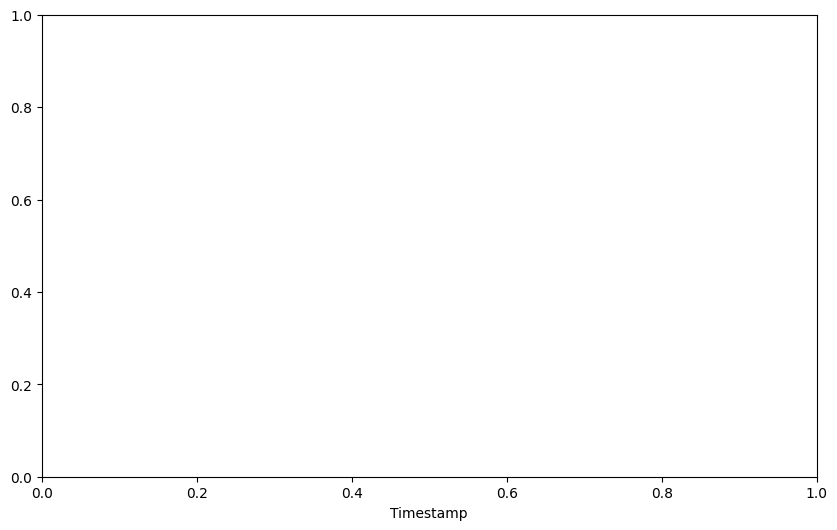

In [53]:
# trying to predict the validation data

forecast = []
for time in range(len(data)-WINDOW_SIZE):
    forecast.append(model.predict(data[time:time+WINDOW_SIZE][np.newaxis]))

forecast = forecast[(int(n*0.7))-WINDOW_SIZE:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plt.xlabel('Timestamp')

ax1 = forecast.plot(color='blue', label='Forecast')
ax2 = results.plot(color='orange', secondary_y=True, label='Results')

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

#pd.plot_series(val_time, val_data)
#pd.plot_series(val_time, results)